In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [2]:
import scanpy as sc
import torch
import scarches as sca
import numpy as np
import pandas as pd

Global seed set to 0


In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [4]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sb

font = {'family' : 'Arial',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
matplotlib.rcParams["figure.dpi"] = 140

### Download Dataset and split into reference dataset and query dataset

In [5]:
adata = sc.read('pbmc_vars_sb.h5ad')

In [6]:
adata = adata[adata.obs['study']!='Villani'].copy()

In [7]:
adata.X = adata.layers["counts"].copy()

In [8]:
sca.utils.add_annotations(adata, 'c2.cp.reactome.v4.0.symbols.gmt', min_genes=12)

In [9]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [10]:
sc.pp.normalize_total(adata)

In [11]:
sc.pp.log1p(adata)

In [12]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    batch_key="batch",
    subset=True)

In [13]:
select_terms = adata.varm['I'].sum(0)>12

In [14]:
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()

In [15]:
adata.varm['I'] = adata.varm['I'][:, select_terms]

In [16]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [17]:
adata.X = adata.layers["counts"].copy()

In [18]:
rm_terms = ['INTERFERON_SIGNALING', 'INTERFERON_ALPHA_BETA_SIGNALIN',
            'CYTOKINE_SIGNALING_IN_IMMUNE_S', 'ANTIVIRAL_MECHANISM_BY_IFN_STI']

In [19]:
rm_terms += ['SIGNALING_BY_THE_B_CELL_RECEPT', 'MHC_CLASS_II_ANTIGEN_PRESENTAT']

In [20]:
ix_f = []
for t in rm_terms:
    ix_f.append(adata.uns['terms'].index(t))

In [21]:
query_mask = adata.varm['I'][:, ix_f[4]][:, None].copy()

In [23]:
for i in ix_f:
    del adata.uns['terms'][i]

In [24]:
adata.varm['I'] = np.delete(adata.varm['I'], ix_f, axis=1)

In [25]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [26]:
rm_b = ["CD20+ B cells", "CD10+ B cells"]

In [27]:
adata = adata[~adata.obs.final_annotation.isin(rm_b)]

### Create TRVAE model and train it on reference dataset

In [28]:
intr_cvae = sca.models.EXPIMAP(
    adata=adata,
    condition_key='study',
    hidden_layer_sizes=[300, 300, 300],
    recon_loss='nb'
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 300 4
	Hidden Layer 1 in/out: 300 300
	Hidden Layer 2 in/out: 300 300
	Mean/Var Layer in/out: 300 276
Decoder Architecture:
	Masked linear layer in, ext, ext_m, cond, out:  276 0 0 4 1972
	with hard mask.
Last Decoder layer: softmax


In [29]:
ALPHA = 0.7

In [30]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
intr_cvae.train(
    n_epochs=200, 
    alpha_epoch_anneal=100, 
    alpha=ALPHA,
    alpha_kl=0.5,
    weight_decay=0., 
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    seed=2020
)

Init the group lasso proximal operator for the main terms.
 |████████████████████| 100.0%  - val_loss: 937.1711611540 - val_recon_loss: 910.8452944548 - val_kl_loss: 52.651730910608
Saving best state of network...
Best State was in Epoch 196


In [31]:
inactive_idx = ~intr_cvae.model.decoder.nonzero_terms()

In [32]:
print('Inactive terms:')
[term for i, term in enumerate(adata.uns['terms']) if inactive_idx[i]]

Inactive terms:


['BMAL1_CLOCK_NPAS2_ACTIVATES_CI',
 'NEF_MEDIATES_DOWN_MODULATION_O',
 'NUCLEAR_SIGNALING_BY_ERBB4',
 'RIP_MEDIATED_NFKB_ACTIVATION_V',
 'ACTIVATED_NOTCH1_TRANSMITS_SIG',
 'RORA_ACTIVATES_CIRCADIAN_EXPRE',
 'YAP1_AND_WWTR1_TAZ_STIMULATED_',
 'CIRCADIAN_REPRESSION_OF_EXPRES',
 'SMAD2_SMAD3_SMAD4_HETEROTRIMER',
 'SIGNALING_BY_FGFR_MUTANTS',
 'NUCLEAR_EVENTS_KINASE_AND_TRAN',
 'BASIGIN_INTERACTIONS',
 'TRANSPORT_OF_MATURE_TRANSCRIPT',
 'REGULATION_OF_ORNITHINE_DECARB',
 'INTEGRIN_ALPHAIIB_BETA3_SIGNAL',
 'CYCLIN_E_ASSOCIATED_EVENTS_DUR',
 'RNA_POL_II_TRANSCRIPTION_PRE_I',
 'GLUCAGON_SIGNALING_IN_METABOLI',
 'M_G1_TRANSITION',
 'CLASS_B_2_SECRETIN_FAMILY_RECE',
 'PD1_SIGNALING',
 'SIGNALING_BY_ROBO_RECEPTOR',
 'AMINO_ACID_AND_OLIGOPEPTIDE_SL',
 'SIGNAL_AMPLIFICATION',
 'SMOOTH_MUSCLE_CONTRACTION',
 'ACTIVATION_OF_NMDA_RECEPTOR_UP',
 'CELL_JUNCTION_ORGANIZATION',
 'PHOSPHOLIPASE_C_MEDIATED_CASCA',
 'ACTIVATED_TAK1_MEDIATES_P38_MA',
 'DEPOSITION_OF_NEW_CENPA_CONTAI',
 'IL1_SIGNALING',
 'REGU

In [33]:
MEAN = False

In [34]:
adata.obsm['X_cvae'] = intr_cvae.get_latent(mean=MEAN)[:, ~inactive_idx]

In [35]:
sc.pp.neighbors(adata, use_rep='X_cvae')

In [36]:
sc.tl.umap(adata)

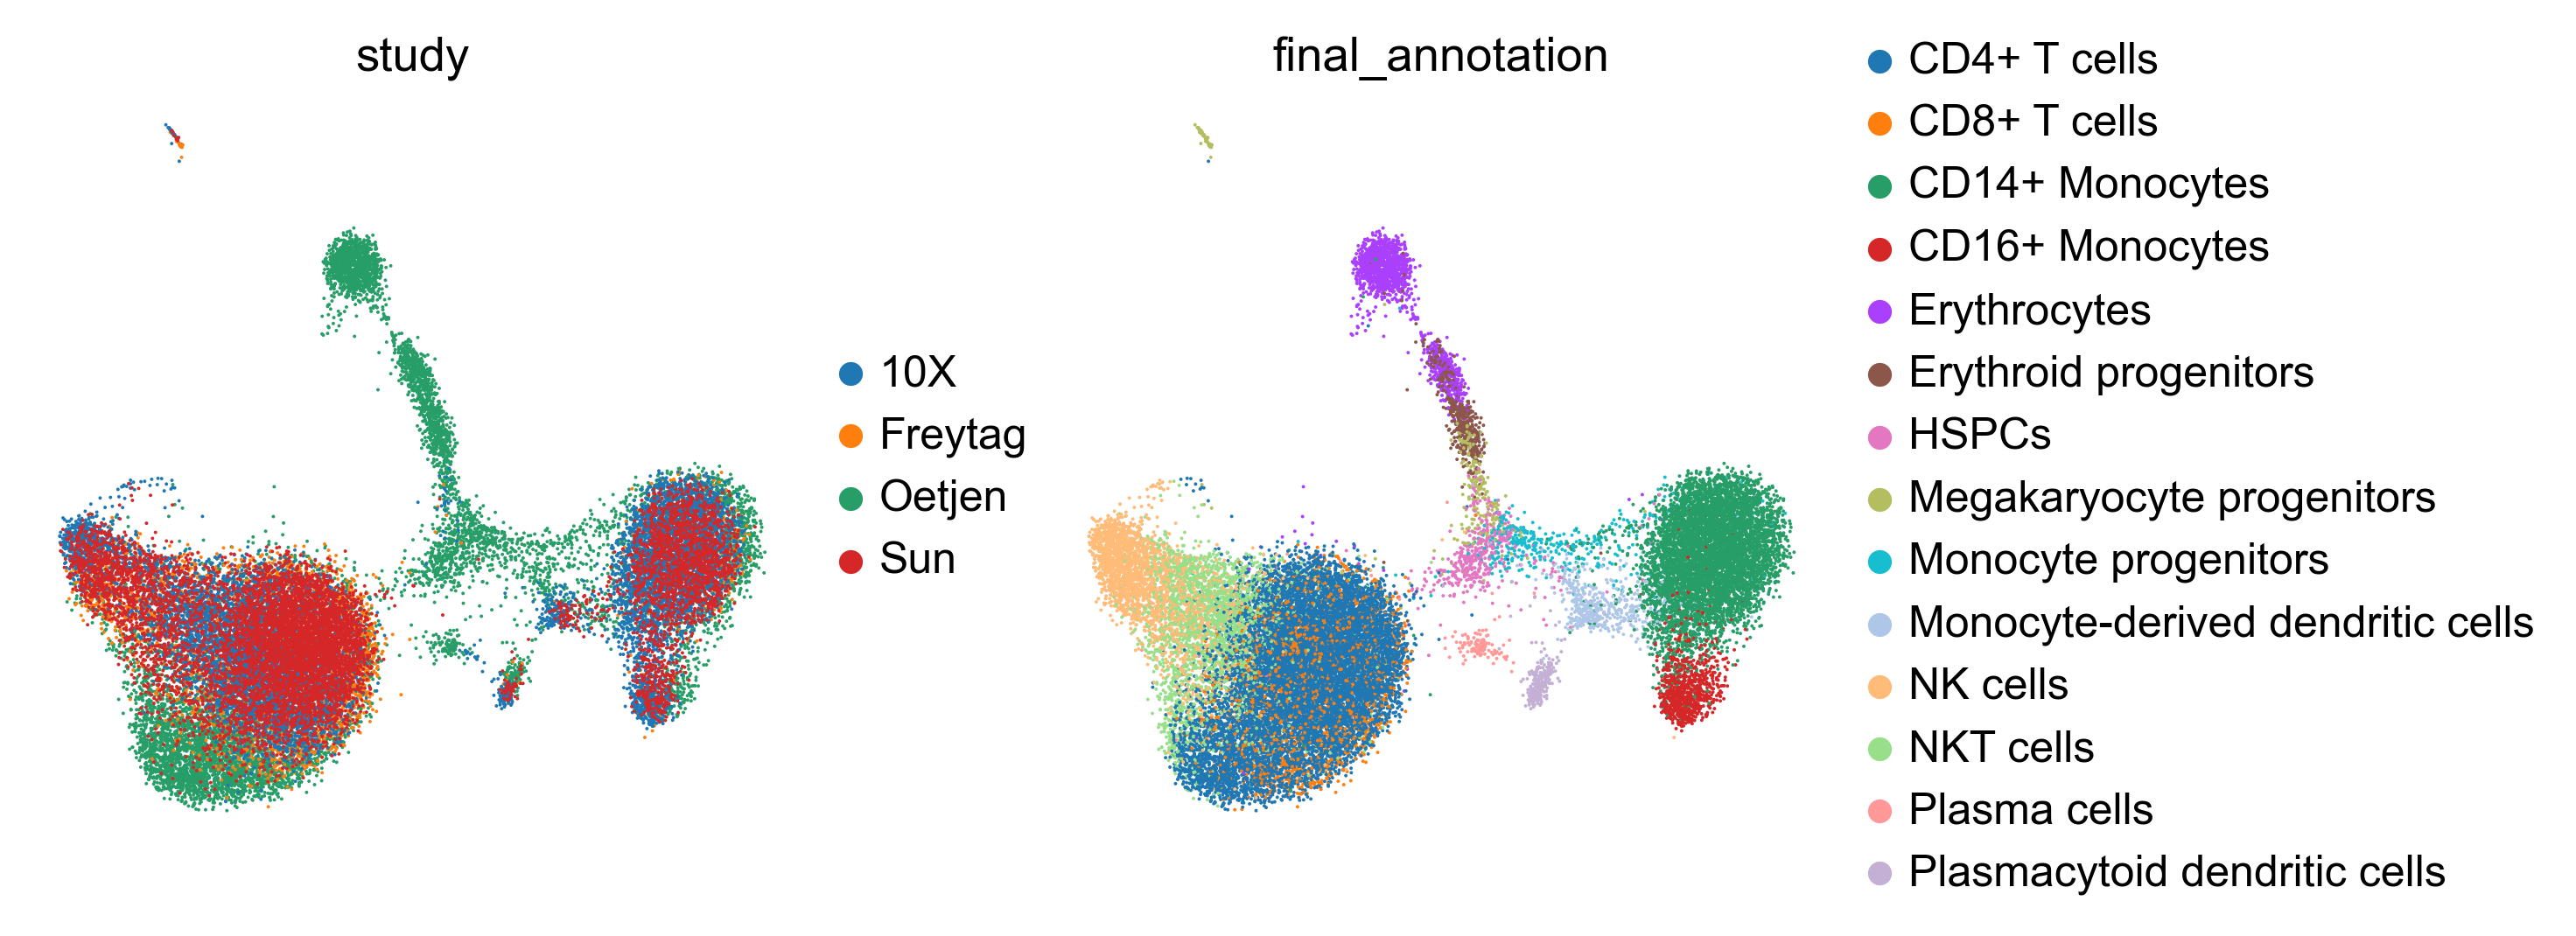

In [37]:
sc.pl.umap(adata, color=['study', 'final_annotation'], frameon=False)

In [38]:
#intr_cvae.save('model_wo_hsic_ref_BINF')

In [16]:
kang = sc.read('kang_count.h5ad')[:, adata.var_names].copy()

In [17]:
kang.obs['study'] = 'Kang'

In [198]:
q_intr_cvae = sca.models.EXPIMAP.load_query_data(kang, intr_cvae,
                                                 unfreeze_ext=True,
                                                 new_n_ext=3,
                                                 new_n_ext_m=1,
                                                 new_ext_mask=query_mask.T,
                                                 new_soft_ext_mask=True,
                                                 use_hsic=True,
                                                 hsic_one_vs_all=True
                                                )


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 300 5
	Hidden Layer 1 in/out: 300 300
	Hidden Layer 2 in/out: 300 300
	Mean/Var Layer in/out: 300 276
	Expanded Mean/Var Layer in/out: 300 4
Decoder Architecture:
	Masked linear layer in, ext, ext_m, cond, out:  276 3 1 5 1972
	with hard mask.
Last Decoder layer: softmax


In [ ]:
q_intr_cvae.train(
    n_epochs=150, 
    alpha_epoch_anneal=50,
    alpha_kl=0.1,
    weight_decay=0., 
    alpha_l1=0.96,
    gamma_ext=0.7,
    gamma_epoch_anneal=50,
    beta=3.,
    seed=2020,
    use_early_stopping=False,
    print_stats=True
)

In [167]:
ext_active = (q_intr_cvae.model.decoder.L0.ext_L.weight.data.abs() > 0).sum(0).cpu().numpy() > 5

In [168]:
inactive_idx = ~q_intr_cvae.model.decoder.nonzero_terms()

In [169]:
inactive_idx[-len(ext_active):] = ~ext_active

In [170]:
terms = adata.uns['terms'].copy()

In [171]:
terms += ['ann_ext_' + str(i) for i in range(q_intr_cvae.model.n_ext_m_decoder)]

In [172]:
terms += ['unannotated_' + str(i) for i in range(len(ext_active))]

In [173]:
MEAN = False

In [ ]:
ext_active

In [175]:
# select unannotated term to plot
idx = [terms.index(term) for term in ['ann_ext_0', 'unannotated_0','unannotated_1', 'unannotated_2']]

In [176]:
latents = q_intr_cvae.get_latent(mean=MEAN)[:, idx]
kang.obs['ann_0'] = latents[:, 0]
kang.obs['unann_0'] = latents[:, 1]
kang.obs['unann_1'] = latents[:, 2]
kang.obs['unann_2'] = latents[:, 3]

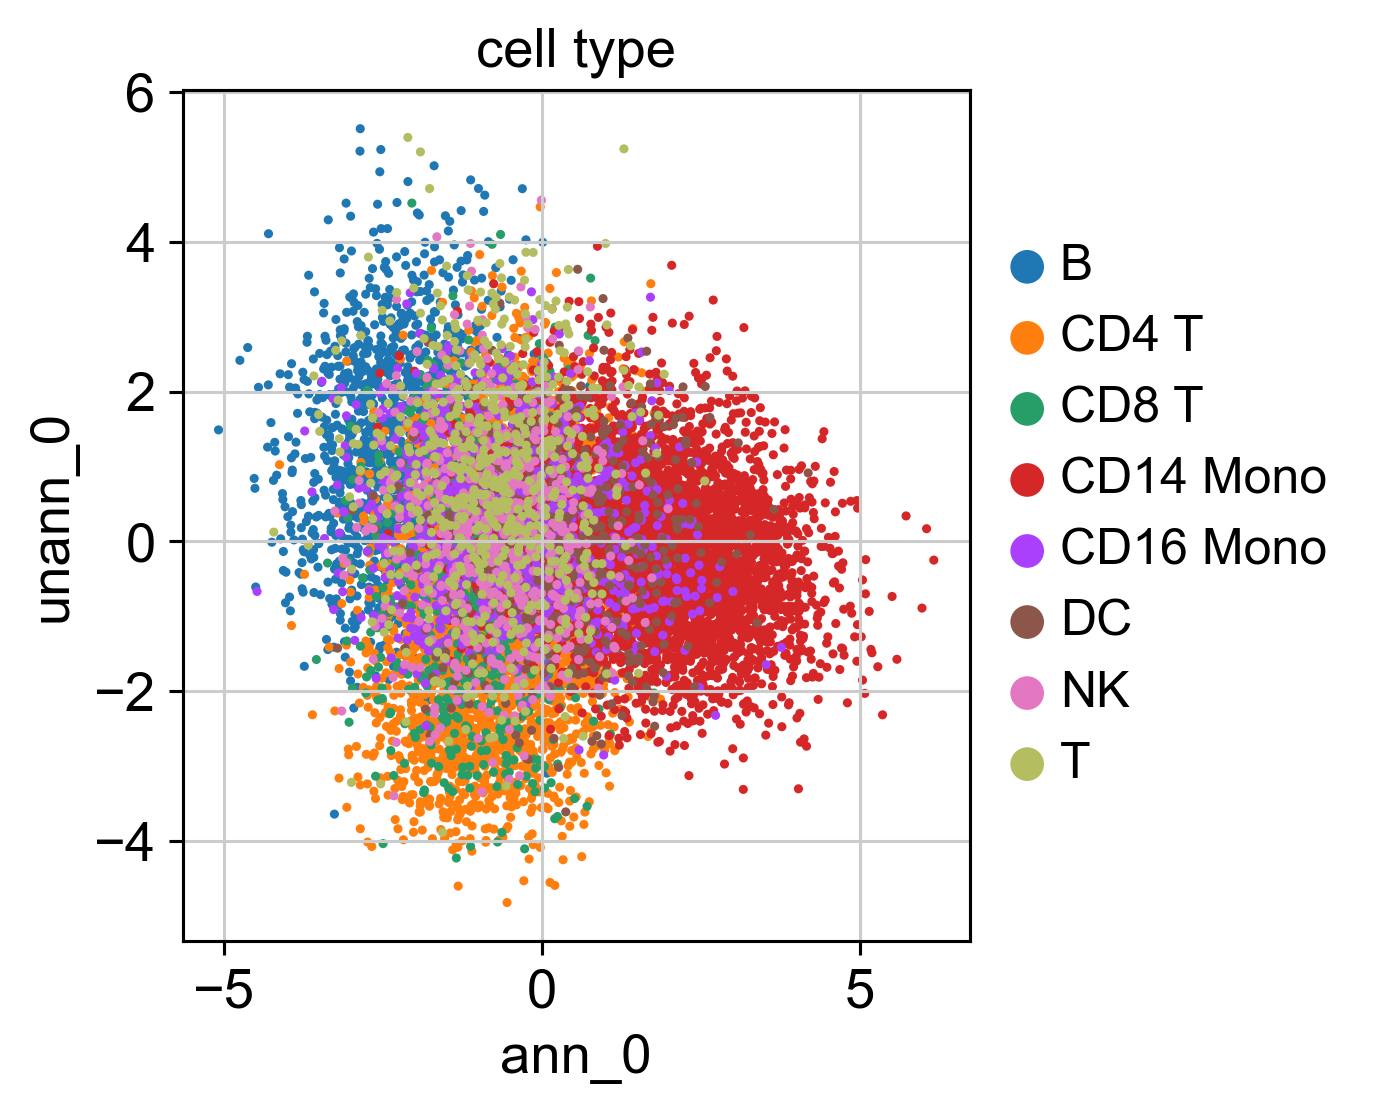

In [181]:
sc.pl.scatter(kang, x='ann_0', y='unann_2',
              color='cell_type',
              size=22)

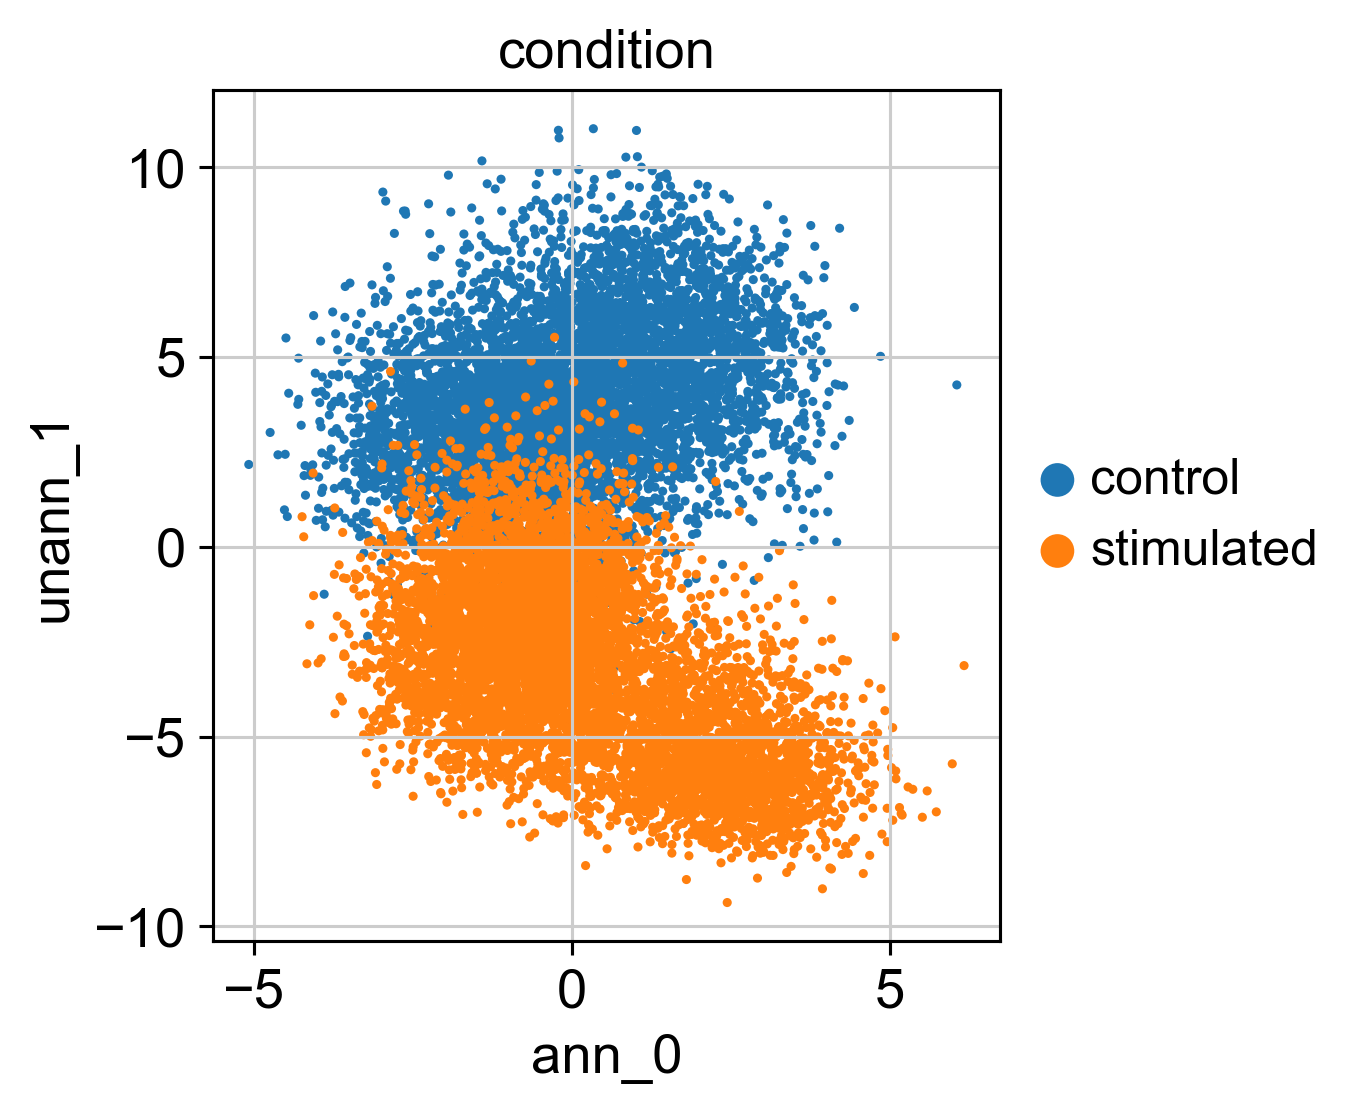

In [180]:
sc.pl.scatter(kang, x='ann_0', y='unann_0',
              color='condition',
              size=22)

In [18]:
kang_pbmc = sc.AnnData.concatenate(adata, kang, batch_key='batch_join')

In [ ]:
kang_pbmc.obsm['X_cvae'] = q_intr_cvae.get_latent(kang_pbmc.X, kang_pbmc.obs['study'].tolist(), mean=MEAN)[:, ~inactive_idx]

In [184]:
sc.pp.neighbors(kang_pbmc, use_rep='X_cvae')
sc.tl.umap(kang_pbmc)

In [20]:
kang_pbmc.strings_to_categoricals()

... storing 'batch' as categorical
... storing 'chemistry' as categorical
... storing 'data_type' as categorical
... storing 'final_annotation' as categorical
... storing 'sample_ID' as categorical
... storing 'species' as categorical
... storing 'study' as categorical
... storing 'tissue' as categorical
... storing 'orig.ident' as categorical
... storing 'stim' as categorical
... storing 'seurat_annotations' as categorical
... storing 'condition' as categorical
... storing 'cell_type' as categorical


In [21]:
kang_pbmc.obs['cell_type_joint'] = kang_pbmc.obs['final_annotation'].tolist()

In [22]:
idx_1 = kang_pbmc.obs['cell_type_joint'].astype(str) == 'nan'
idx_2 = kang_pbmc.obs['cell_type'].astype(str) != 'nan'
kang_pbmc.obs['cell_type_joint'][idx_1] = kang_pbmc.obs['cell_type'][idx_2].tolist()

In [23]:
categories = np.unique(kang_pbmc.obs['cell_type_joint'])

In [24]:
categories

array(['B', 'CD10+ B cells', 'CD14 Mono', 'CD14+ Monocytes', 'CD16 Mono',
       'CD16+ Monocytes', 'CD20+ B cells', 'CD4 T', 'CD4+ T cells',
       'CD8 T', 'CD8+ T cells', 'DC', 'Erythrocytes',
       'Erythroid progenitors', 'HSPCs', 'Megakaryocyte progenitors',
       'Monocyte progenitors', 'Monocyte-derived dendritic cells', 'NK',
       'NK cells', 'NKT cells', 'Plasma cells',
       'Plasmacytoid dendritic cells', 'T'], dtype=object)

In [25]:
celltypes_replace = {}
celltypes_replace['CD20+ B cells'] = 'B'
celltypes_replace['CD4 T'] = 'CD4+ T cells'
celltypes_replace['CD8 T'] = 'CD8+ T cells'
celltypes_replace['CD14 Mono'] = 'CD14+ Monocytes'
celltypes_replace['CD16 Mono'] = 'CD16+ Monocytes'
celltypes_replace['NK'] = 'NK cells'

In [26]:
for cat in categories:
    if cat in celltypes_replace:
        kang_pbmc.obs['cell_type_joint'][kang_pbmc.obs['cell_type_joint']==cat] = celltypes_replace[cat]

In [27]:
kang_pbmc.obs['condition_joint'] = kang_pbmc.obs['condition'].copy()

In [28]:
kang_pbmc.obs['condition_joint'][kang_pbmc.obs['condition_joint'].isna()] = 'control'

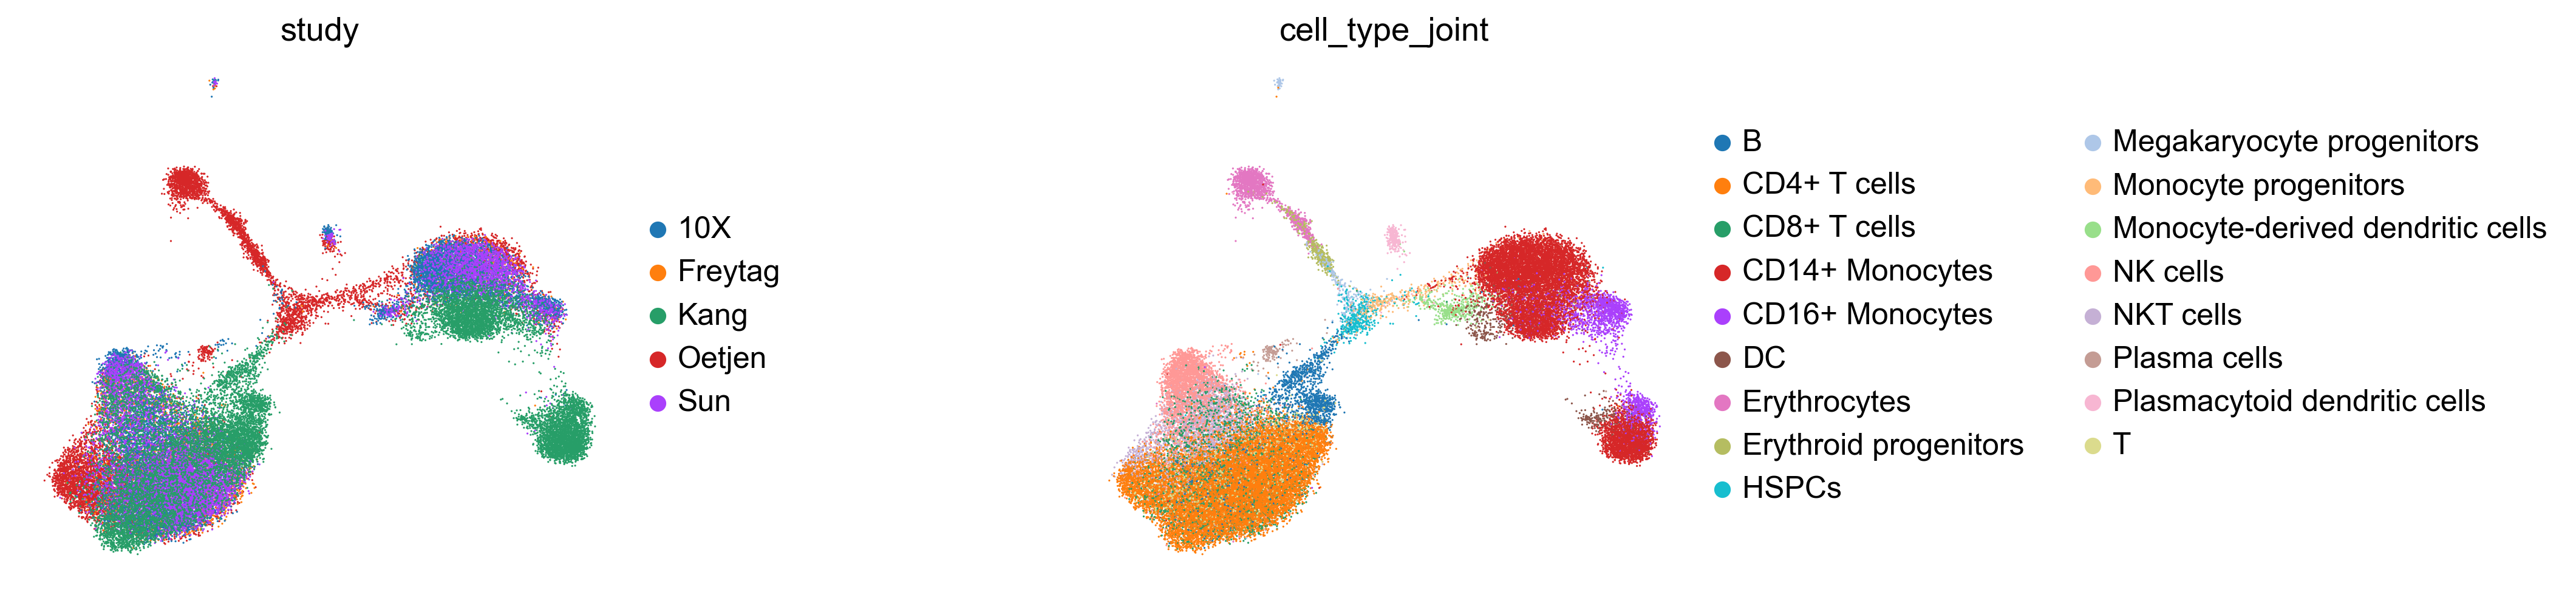

In [194]:
sc.pl.umap(kang_pbmc, color=['study', 'cell_type_joint'], frameon=False, wspace=0.6)

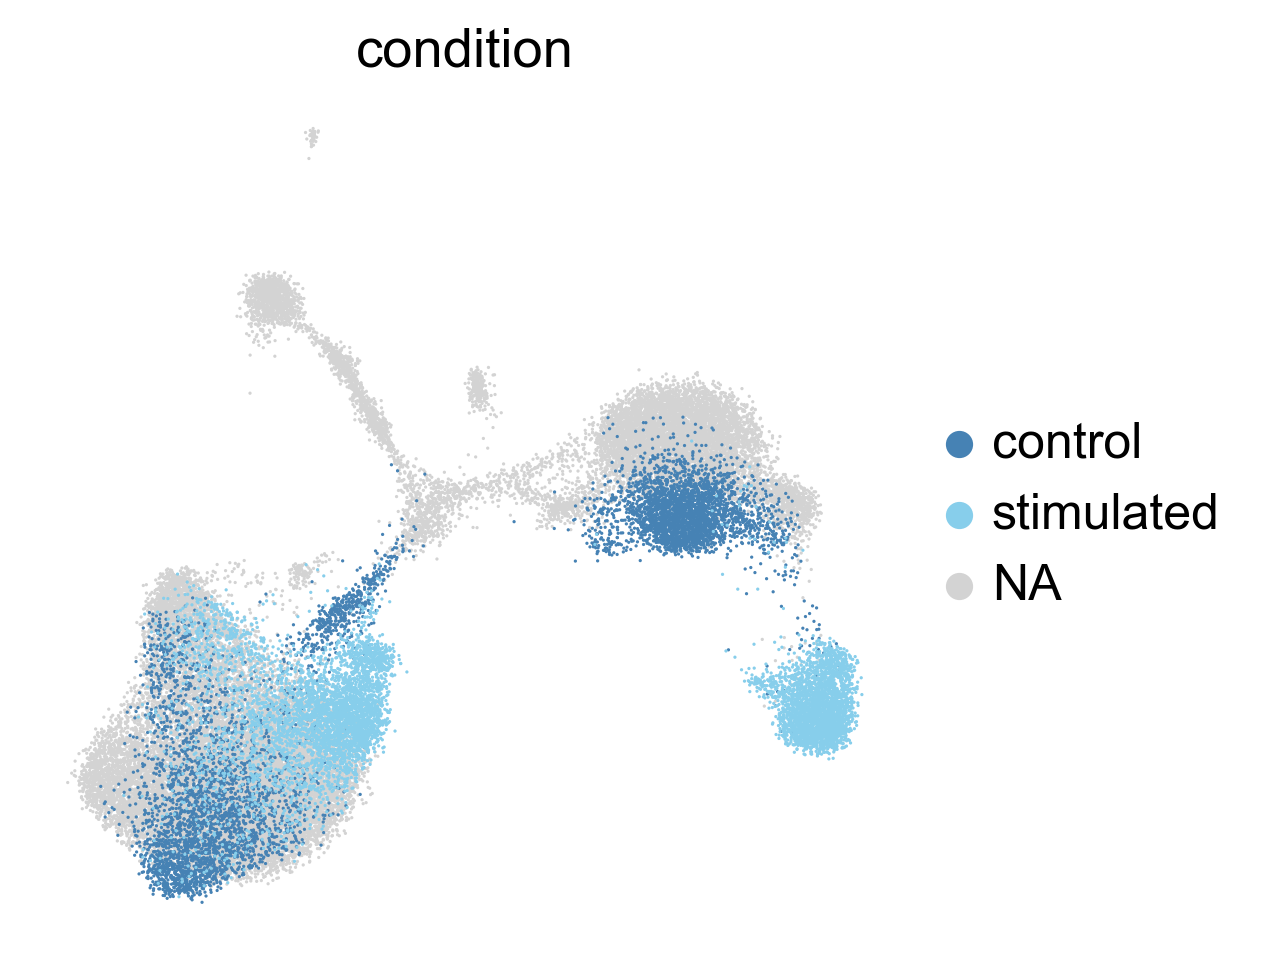

In [195]:
sc.pl.umap(kang_pbmc, color='condition',
           frameon=False, 
           wspace=0.6,
           palette=['steelblue', 'skyblue', 'red'])

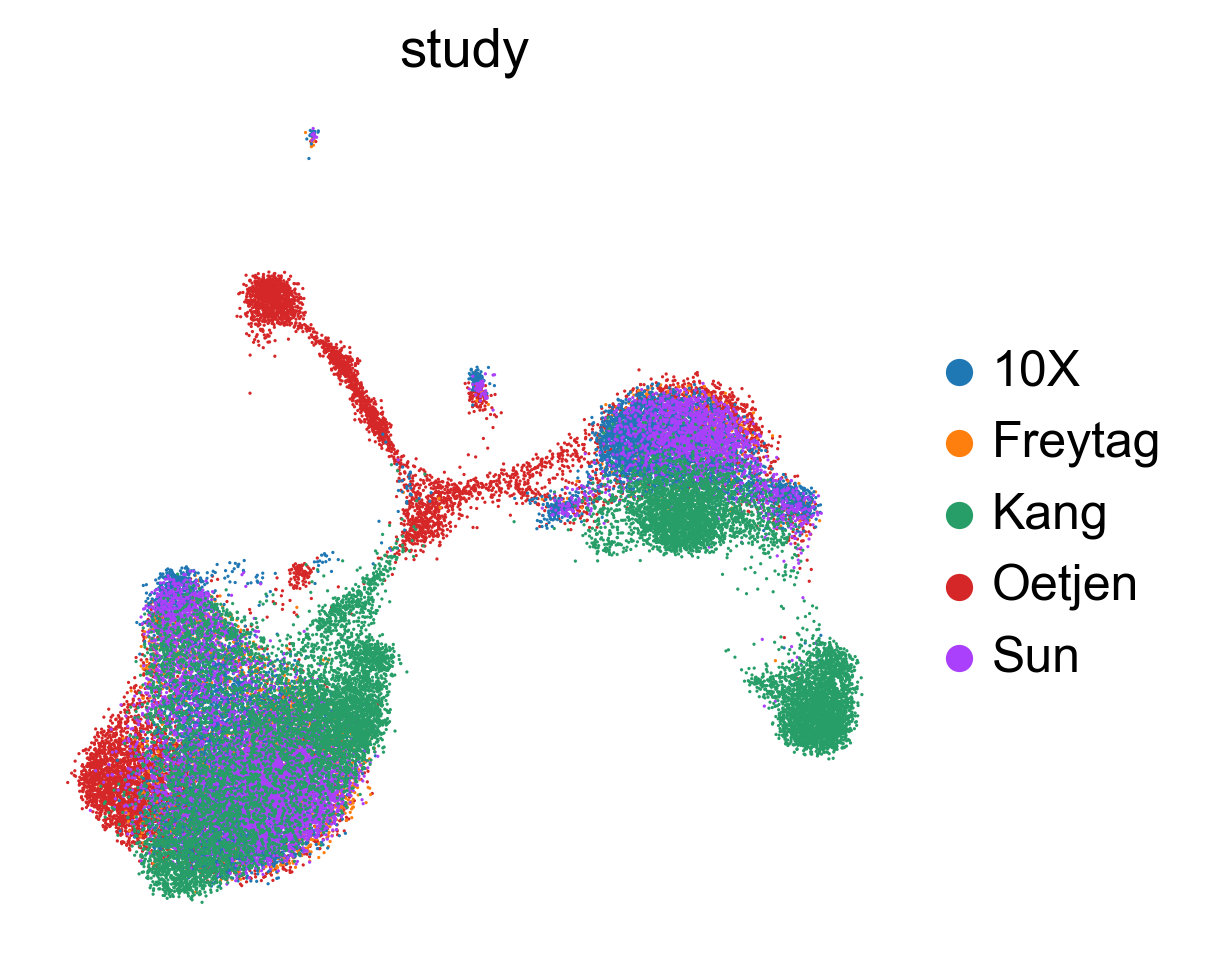

In [196]:
sc.pl.umap(kang_pbmc, color='study', frameon=False, wspace=0.6)

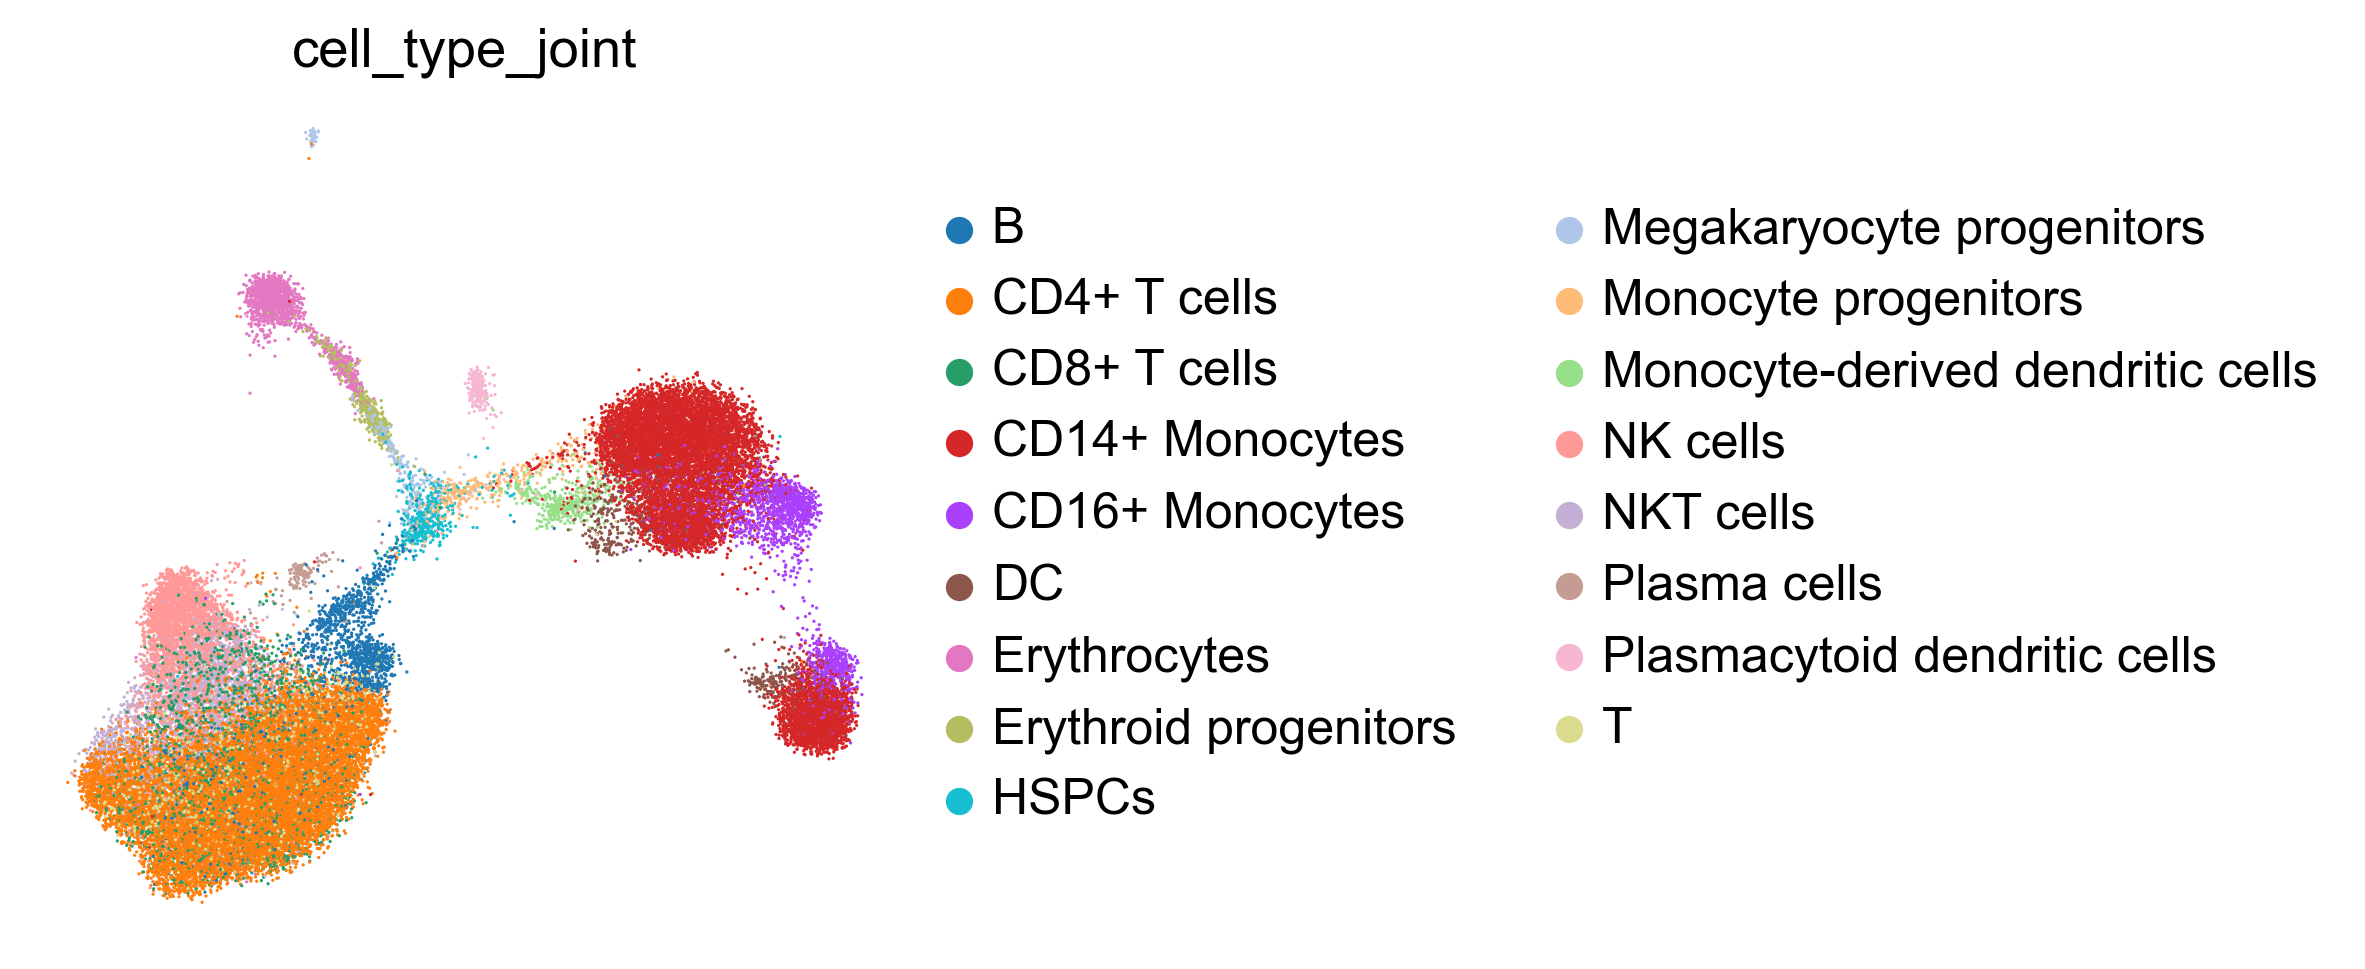

In [197]:
sc.pl.umap(kang_pbmc, color='cell_type_joint', frameon=False, wspace=0.6)

In [157]:
latents = q_intr_cvae.get_latent(kang_pbmc.X, kang_pbmc.obs['study'].tolist(), mean=MEAN)[:, idx]
kang_pbmc.obs['B masked'] = latents[:, 0]
kang_pbmc.obs['term 2'] = latents[:, 1]
kang_pbmc.obs['term 3'] = latents[:, 2]
kang_pbmc.obs['term 1'] = latents[:, 3]

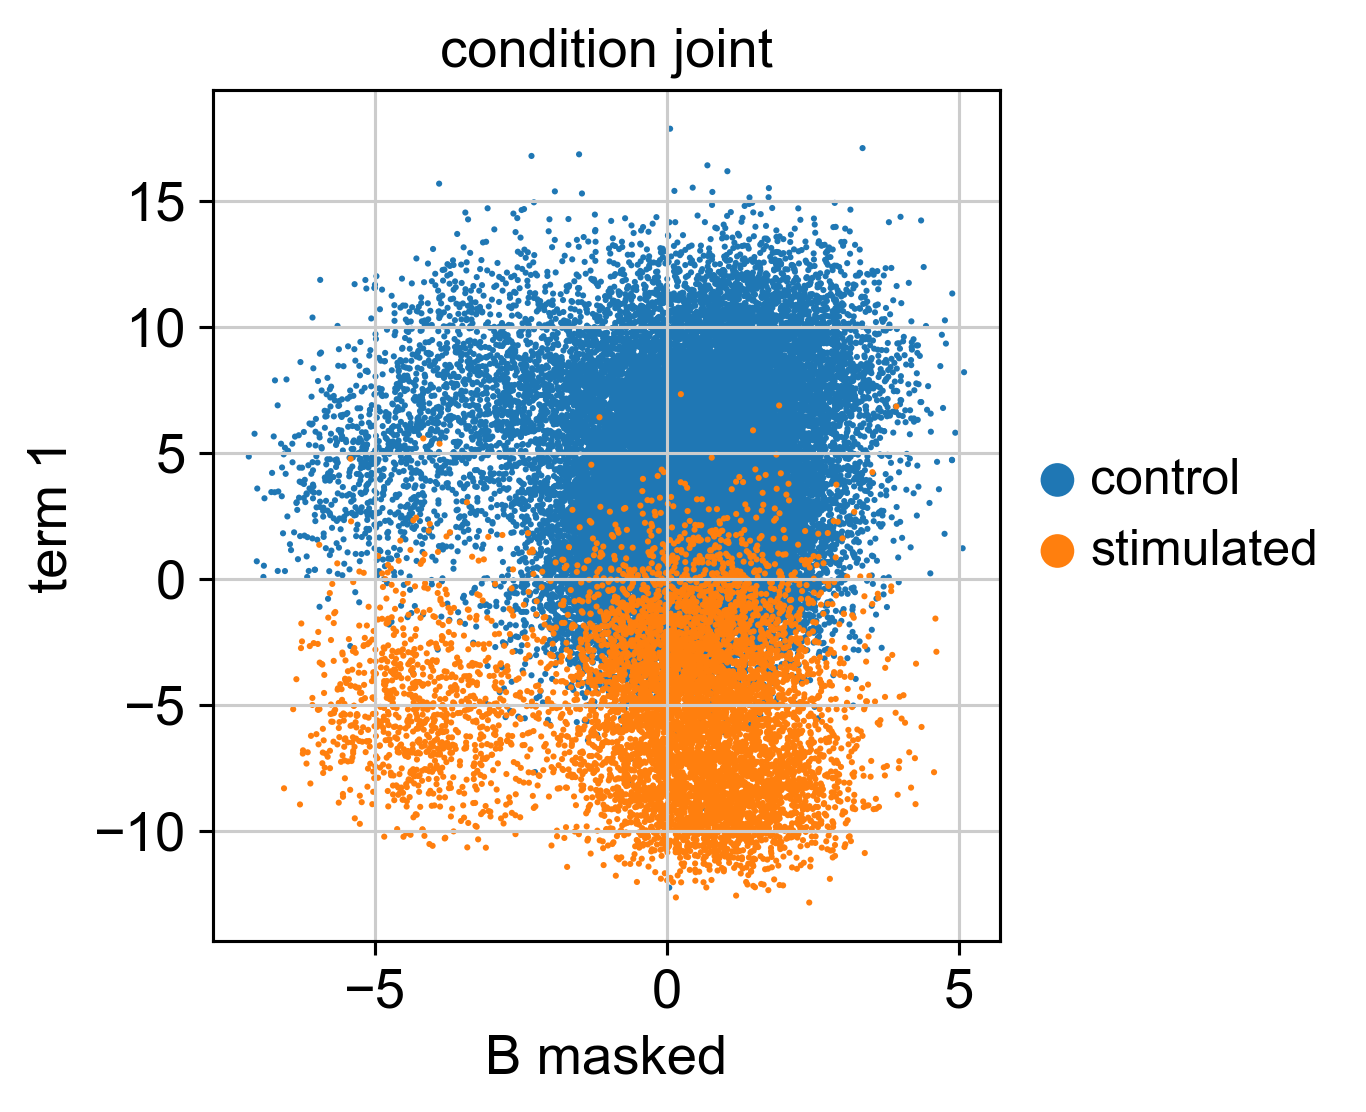

In [160]:
sc.pl.scatter(kang_pbmc, x='B masked', y='term 1',
              color='condition_joint', size=10)

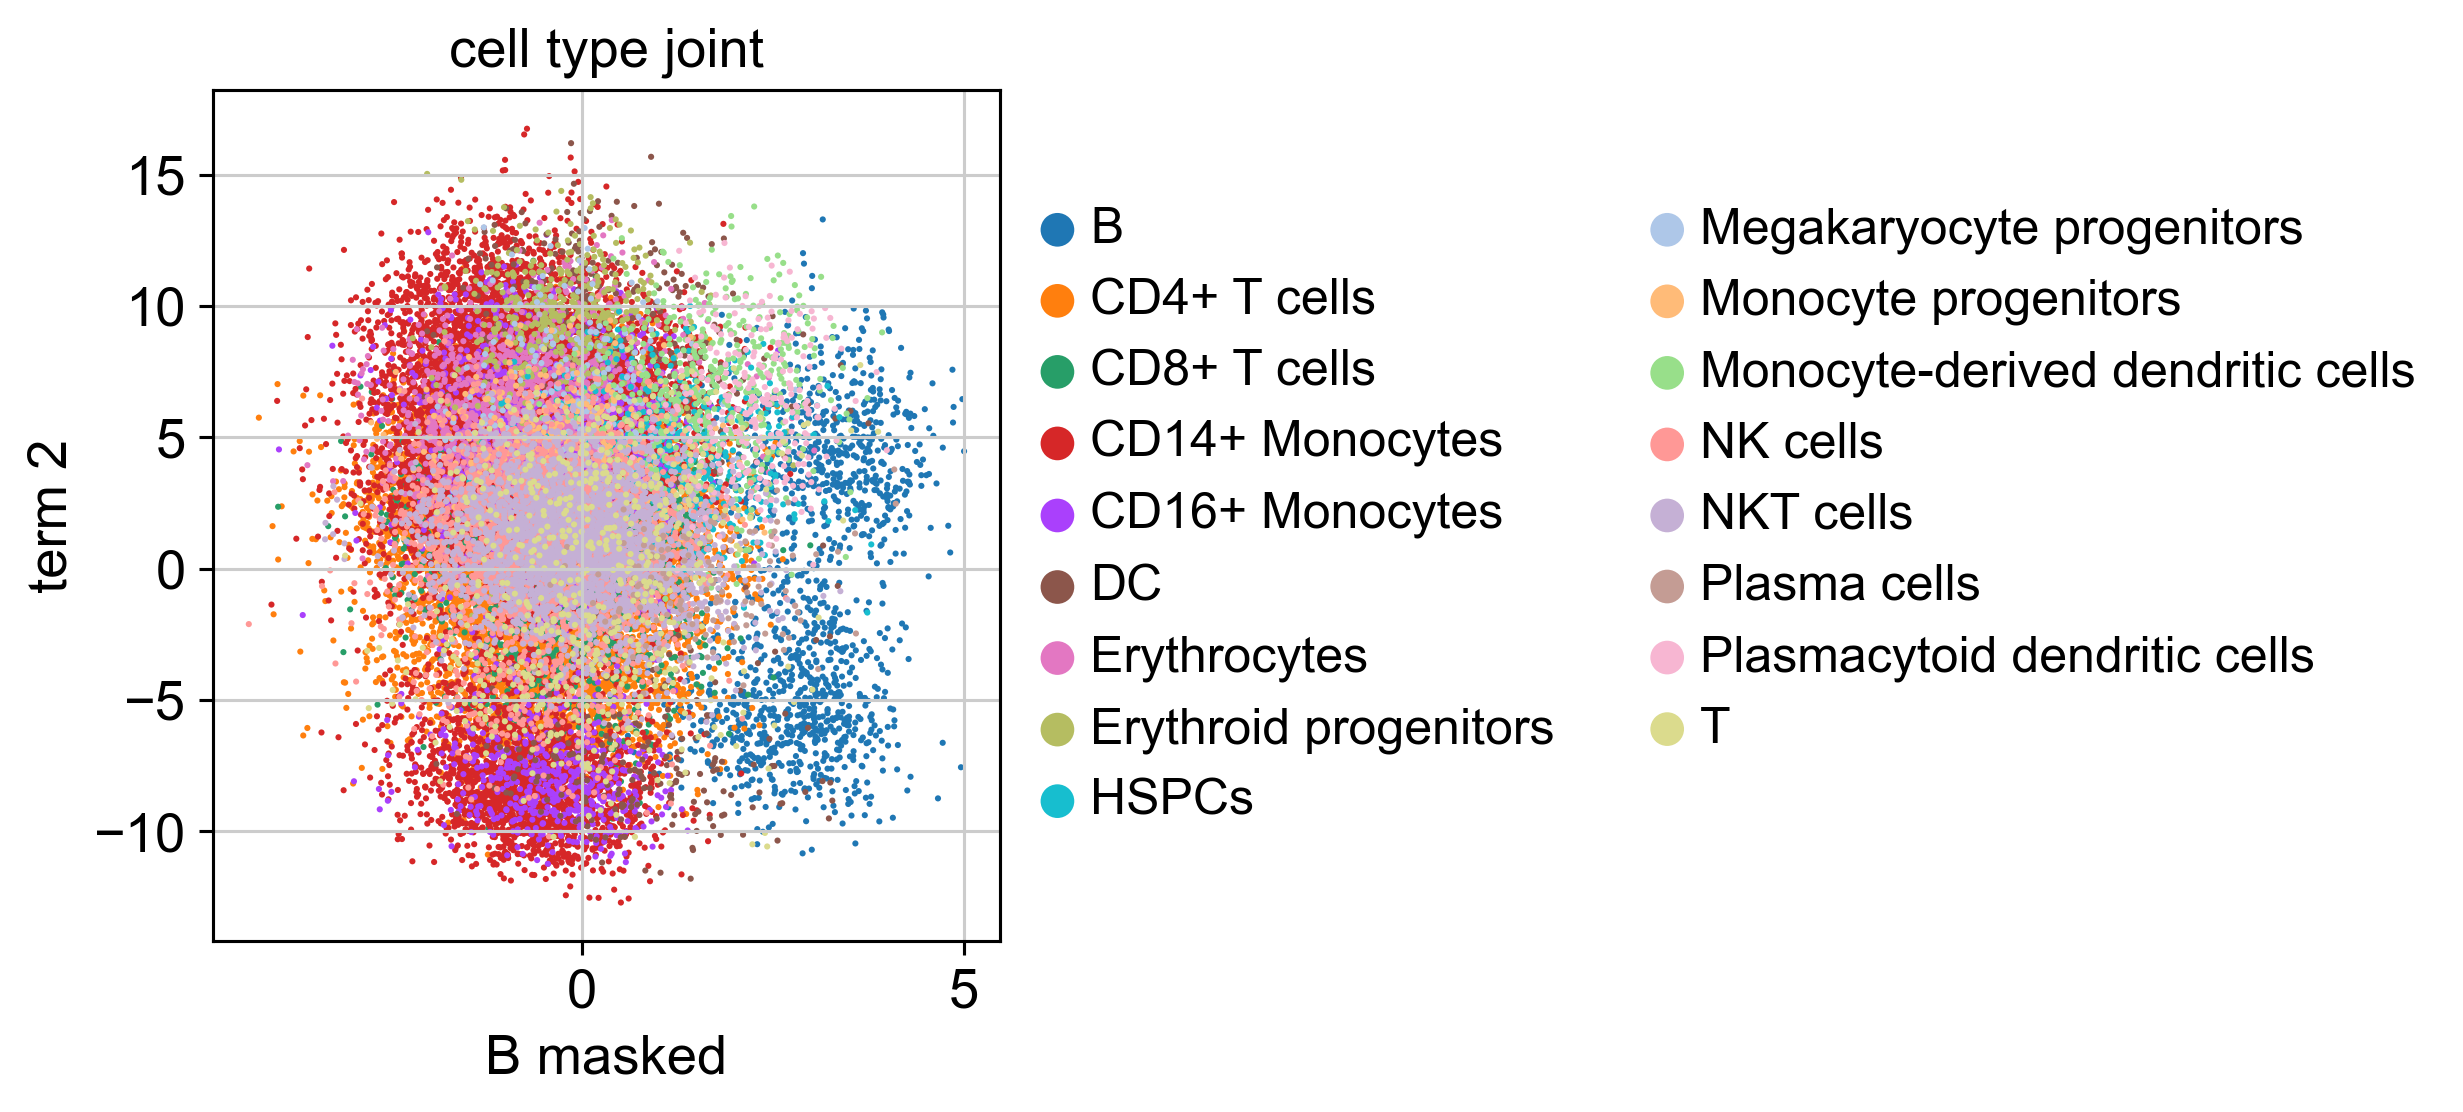

In [295]:
sc.pl.scatter(kang_pbmc, x='B masked', y='term 2',
              color='cell_type_joint', size=10)